# Coronavirus Statistics

This notebook is a work-in-progress for playing with the coronavirus statistics published by [Johns Hopkins university github repo](https://github.com/CSSEGISandData/COVID-19), which forms the foundation for the visualisations published in their [COVID-19 Dashboard](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

### Download and process the data directly from Github

_Note_ : loading data at the moment requires an internet connection, and every time this cell is run it will fetch the raw data afresh.

Strip out some data related to cruise ships but assigned to Canada, and group and sum the data for countries where the raw data is recorded by state/province/region.

In [1]:
from datetime import datetime
from IPython.display import Markdown as md

md(f"#### Last Updated: {datetime.today().strftime('%Y-%m-%d %H:%M')}")

#### Last Updated: 2020-05-08 15:37

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

countries_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
cases_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

countries = pd.read_csv(countries_csv)
cases = pd.read_csv(cases_csv)
cases = cases[~cases["Province/State"].isin(["Recovered", "Diamond Princess", "Grand Princess"])].groupby("Country/Region").sum()
deaths = pd.read_csv(deaths_csv)
deaths = deaths[~deaths["Province/State"].isin(["Recovered", "Diamond Princess", "Grand Princess"])].groupby("Country/Region").sum()

#### Limit the data to the countries in which we're interested
We're not interested in all data. For cases, we take all the countries where the number of cases is greater than the number of Swiss cases. For deaths, we take the top twenty cases.

In [3]:
last_col_name = cases.columns[-1]

cases_ch = cases.loc["Switzerland"]
num_cases_ch = cases_ch[last_col_name]
cases_interest = cases[cases[last_col_name] >= int(num_cases_ch)]
cases_interest = cases_interest.sort_values(by=last_col_name, ascending=False)

deaths_interest = deaths.sort_values(by=last_col_name, ascending=False).iloc[:20, :]

By changing `num_days` we can control the number of days shown in the graphs. The first days of data are only interesting for China, whereas the rest of the world picks up starting in early March. Uncomment one of the variants for `num_days` below, depending on what you want to see:

* Choose a starting date
* Choose a number of historical days since today
* Choose all days for which there is data

In [4]:
# Starting date, e.g. March 15 2020
num_days = (datetime.today() - datetime(2020, 3, 15)).days

# Number of historical days
# num_days = 30

# All data
# num_days = None

## Graphs

The graphs below use various subplots to try and allow different y-axis scales, given the wide range of cases and deaths. The various proportions will probably need to be adjusted as time progresses and the actual numbers and relative scales evolve.

### Numbers of confirmed cases

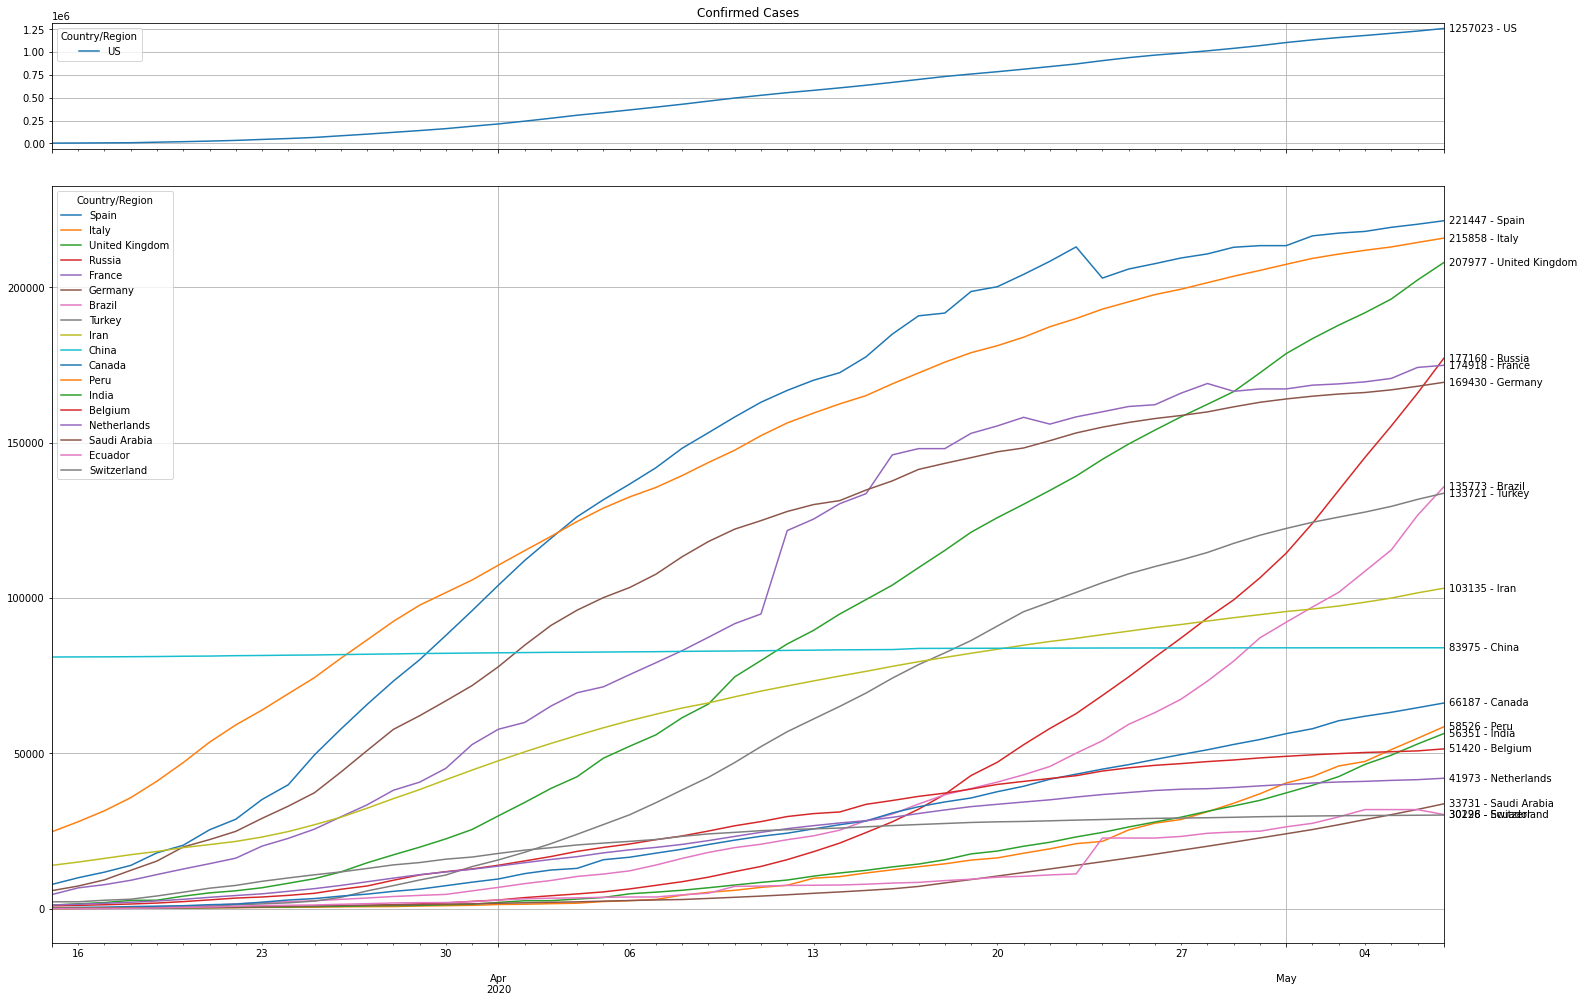

In [5]:
cases_trim = cases_interest.T.iloc[3:, :]

if num_days:
    cases_trim = cases_trim.iloc[-num_days:, :]

cases_trim.index = pd.to_datetime(cases_trim.index)

fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [1, 6]})
fig.tight_layout(h_pad=0)
cases_plotUS = cases_trim.iloc[:, :1].plot(title="Confirmed Cases", figsize=(22, 15), grid=True, ax=axes[0])
cases_plotROW = cases_trim.iloc[:, 1:].plot(grid=True, ax=axes[1])

last_row = cases_trim.iloc[-1:, :]
plot = cases_plotUS
for k, v in last_row.items():
    plot.annotate("%d - %s" % (v[0], v.name), (last_row.index[0], v[0]), xytext=(5, -3), textcoords="offset points")
    plot = cases_plotROW

### Number of confirmed deaths

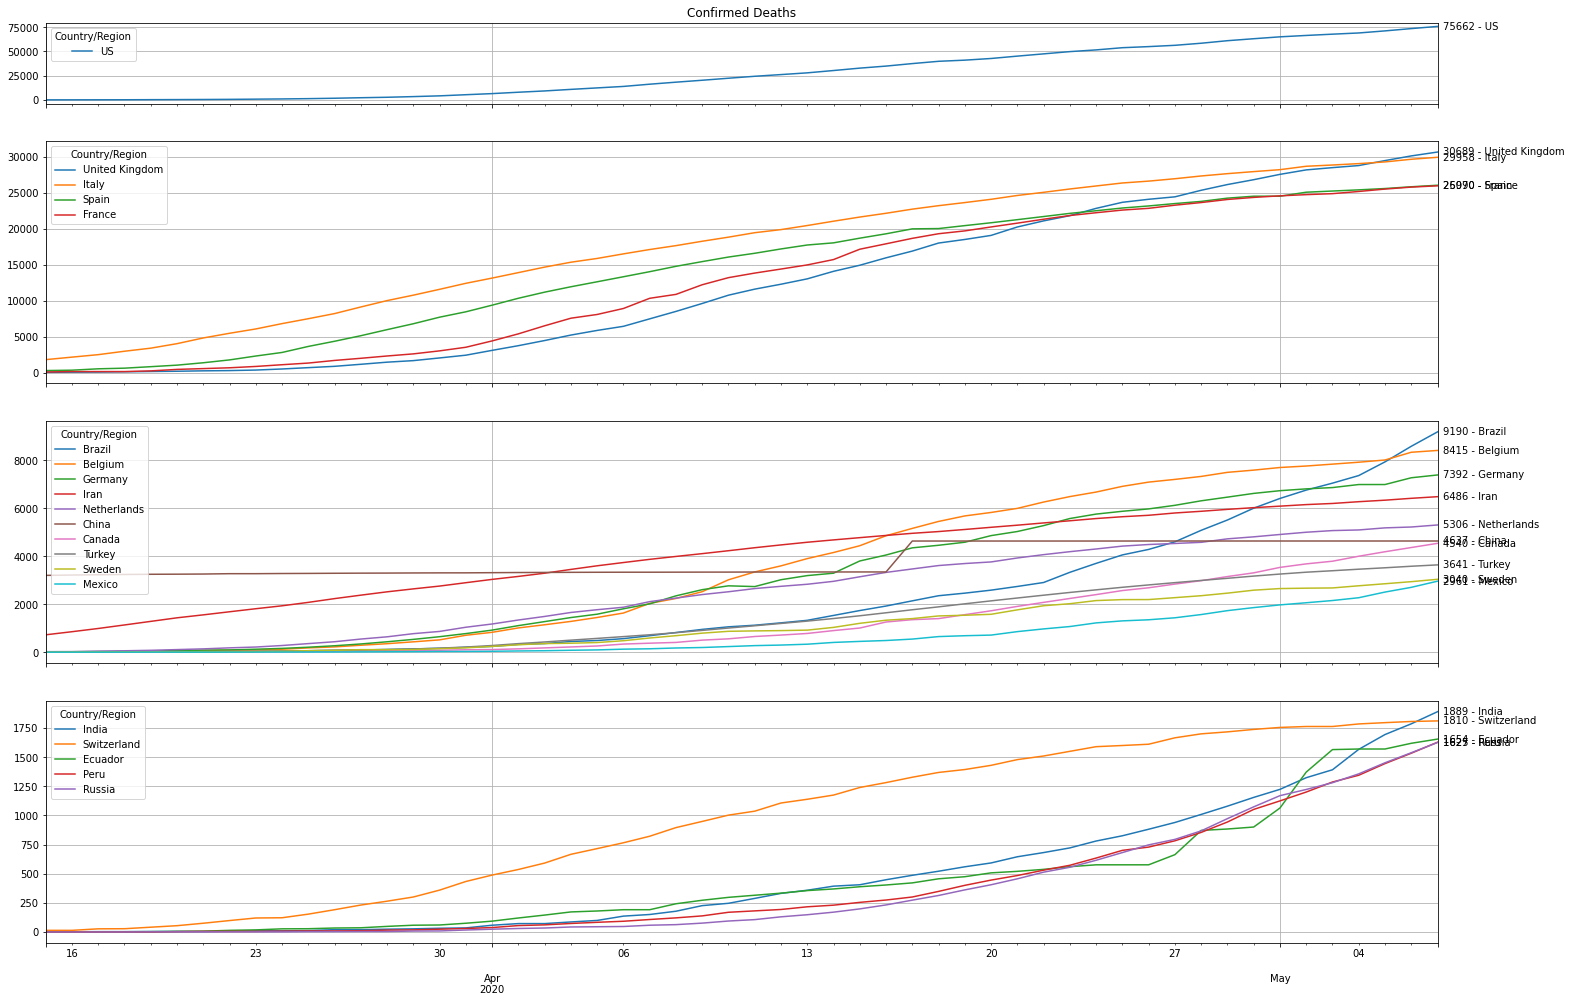

In [6]:
deaths_trim = deaths_interest.T.iloc[3:, :]

if num_days:
    deaths_trim = deaths_trim.iloc[-num_days:, :]

deaths_trim.index = pd.to_datetime(deaths_trim.index)

fig, axes = plt.subplots(4, 1, sharex=True, gridspec_kw={"height_ratios": [1, 3, 3, 3]})
fig.tight_layout(h_pad=0)
deaths_plotUS = deaths_trim.iloc[:, :1].plot(title="Confirmed Deaths", figsize=(22, 15), grid=True, ax=axes[0])
deaths_plotEU1 = deaths_trim.iloc[:, 1:5].plot(grid=True, ax=axes[1])
deaths_plotEU2 = deaths_trim.iloc[:, 5:15].plot(grid=True, ax=axes[2])
deaths_plotROW = deaths_trim.iloc[:, 15:].plot(grid=True, ax=axes[3])

last_row = deaths_trim.iloc[-1:, :]
count = 0
for k, v in last_row.items():
    if count < 1:
        plot = deaths_plotUS
    elif count < 5:
        plot = deaths_plotEU1
    elif count < 15:
        plot = deaths_plotEU2
    else:
        plot = deaths_plotROW
    plot.annotate("%d - %s" % (v[0], v.name), (last_row.index[0], v[0]), xytext=(5, -3), textcoords="offset points")
    count += 1

### Number of confirmed deaths per 100'000 inhabitants over time

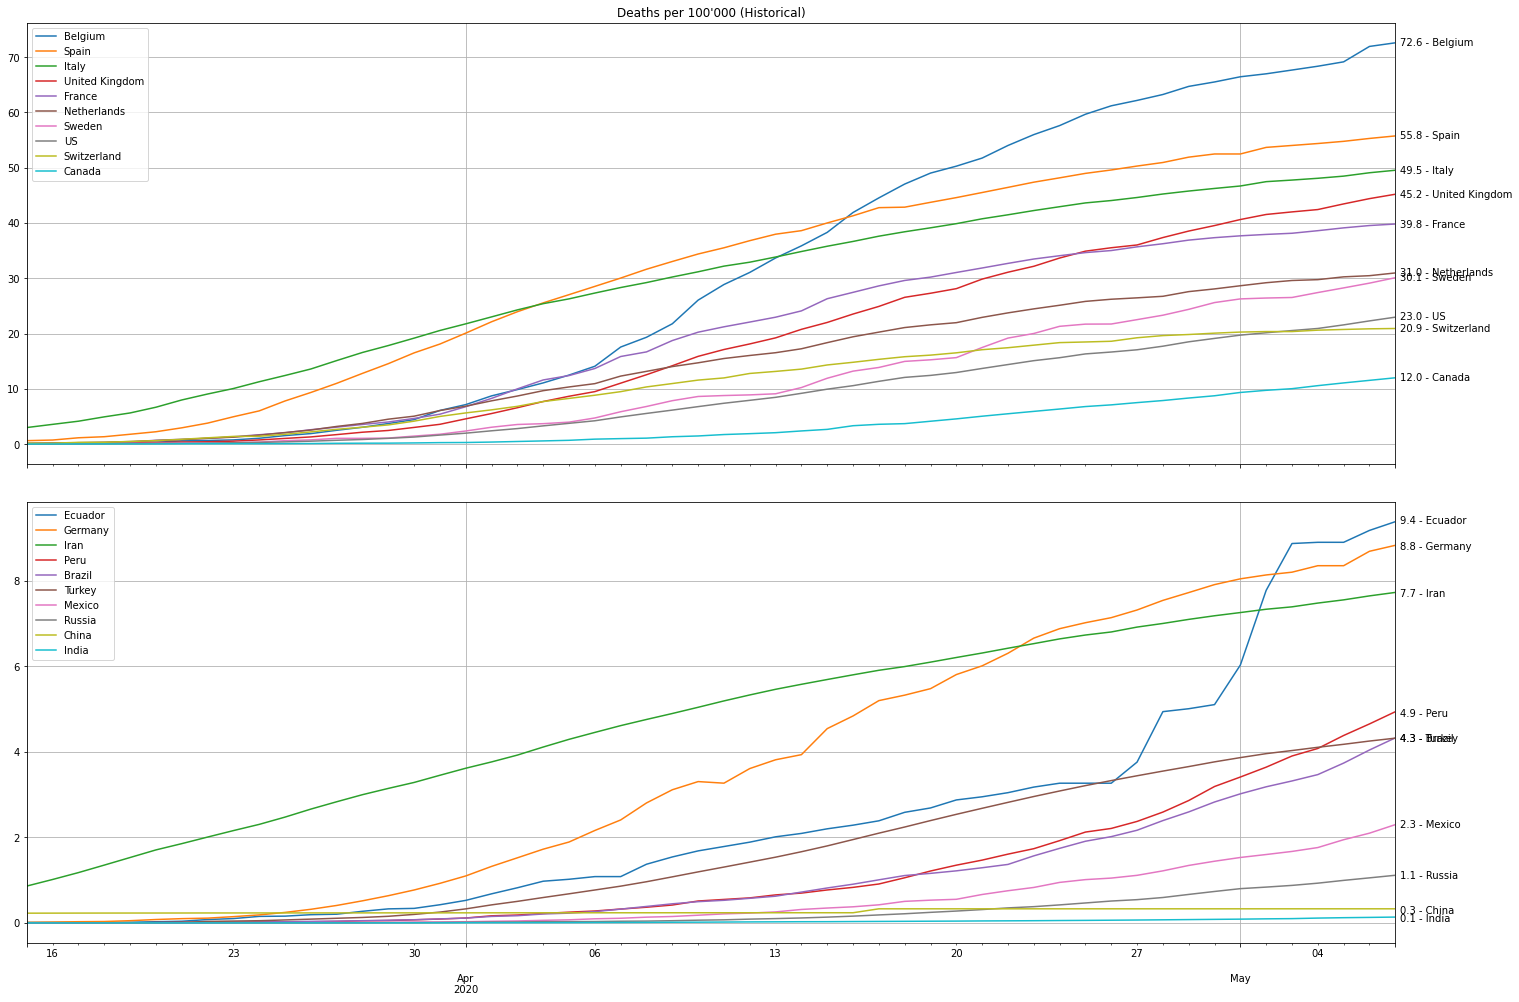

In [7]:
dpm = pd.DataFrame()

for k, v in deaths_trim.items():
    pop = int(countries[countries["Combined_Key"] == k]["Population"])
    factor = 100000 / pop 
    series = v.mul(factor)
    dpm = dpm.append(series)

dpm = dpm.sort_values(by=last_col_name, ascending=False).T

fig, axes = plt.subplots(2, 1, sharex=True)#, gridspec_kw={"height_ratios": [2, 1]})
fig.tight_layout(h_pad=0)
dpm_plot1 = dpm.iloc[:, :10].plot(title="Deaths per 100'000 (Historical)", figsize=(22, 15), grid=True, ax=axes[0])
dpm_plot2 = dpm.iloc[:, 10:].plot(grid=True, ax=axes[1])

last_row = dpm.iloc[-1:, :]
last_row
count = 0
for k, v in last_row.items():
    if count < 10:
        plot = dpm_plot1
    else:
        plot = dpm_plot2
    val = round(v[0], 1)
    plot.annotate("%.1f - %s" % (val, v.name), (v.index[0], val), xytext=(5, -3), textcoords="offset points")
    count += 1

### Current number of confirmed deaths per 100'000 inhabitants

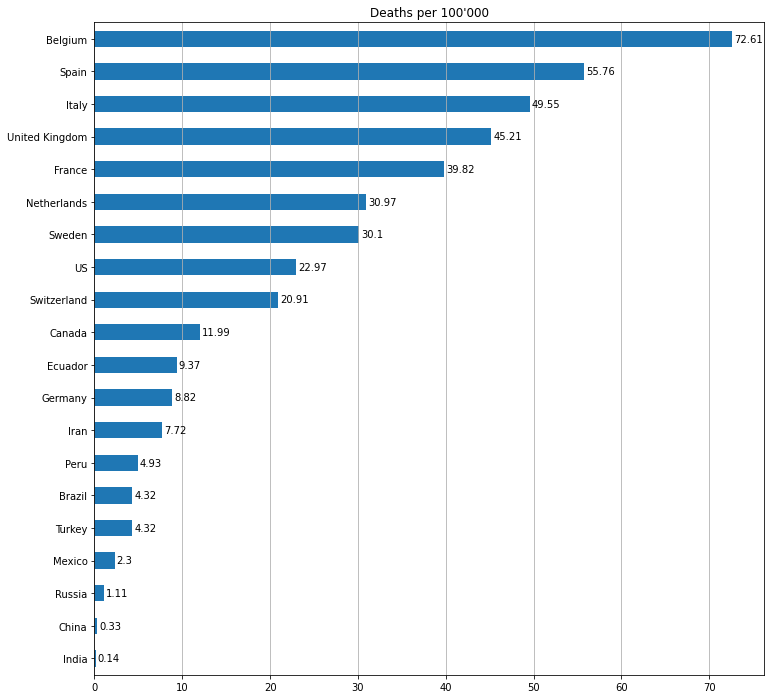

In [8]:
dpm_today = dpm.T.iloc[:, -1:].sort_values(by=last_col_name)
fig = dpm_today.plot.barh(title="Deaths per 100'000", figsize=(12, 12), legend=None)
fig.grid(axis="x")

i = 0
for k, v in dpm_today.iterrows():
    val = round(v[-1], 2)
    fig.annotate(val, (val, i), xytext=(2, -3), textcoords="offset points")
    i += 1